# Linear models

## Generate data

We are given a set of coefficients. We want to try different methods to find a set of coefficients for the linear model that approximates the given coefficients. 

We are going to generate $m$ examples, each of them consists of $n$ features. 

In our exmples, $n = 3$. Each label (a target value a.k.a $y$) will look like $1  x_0 + 2 x_1 + 3 x_2 + \texttt{noise}$. We add noise to make the task a bit harder for the model.

In [2]:
import random
import numpy as np

 
"""
Generates training dataset
- `A` is an array of given coefficients
- `m` is the number of exmaples to generate
- `noise` is the scale of noise that will be added to the target variable 
to make the data more realistic.
"""
def generate_data(A, m, noise):
    n = len(A)
    X = np.random.normal(0, 1, (m, n))
    y = np.dot(X, A) + np.random.normal(0, noise, m)
    return X, y


X_train, y_train = generate_data([1, 2, 3], 1000, 0.01)

## Solve with Moore-Penrose inverse method

We want to solve the equation $Xa = y$ => $a = X^{-1}y$. If $X$ is not inverse, use $a = (X^TX)^{-1}X^Ty$

In [3]:
def solve_pseudo_inverse(X, y):
    matrix = np.linalg.inv(np.dot(X.T, X))
    return np.dot(np.dot(matrix, X.T), y)

print(solve_pseudo_inverse(X_train, y_train))

[1.00045594 2.00006606 2.99912541]


As you can see, w got coefficients that are really close to the initial coefs `[1, 2, 3]`.

## Solve using `LinearRegression` model

`solve_sklearn` uses `LinearRegression` model to fit the training data and find the coefficients.

In [4]:
import sklearn
from sklearn.linear_model import LinearRegression


def solve_sklearn(X, y):
    model = LinearRegression()
    model.fit(X, y)
    print(model.coef_)


solve_sklearn(X_train, y_train)

[1.00045459 2.00009506 2.99912473]


## Solve using the Stochastic Gradient Descent function

We can use a loss function $L = (y_{pred} - y_{real})^2 = (\sum\limits_0^{n-1}a_ix_i - y_{real})^2$. We are going to use the gradient of the loss function. The gradient is a matrix consisting of such derivatives: $\frac{\Delta L}{\Delta a_i} = L'_{a_i} = 2 (a_0x_0+...+a_{n-1}x_{n-1} - y_{real}) x_i$

The `solve_sgd` function first initializes vector `a` with zeros and iteratively updates it in order to minimize the loss function error. In each iteration, it computes the prediction t, computes the gradient for the current vector `a` and updates the coefficients.

In [5]:
def solve_sgd(X, y, iterations, learning_rate):
    n = X.shape[1]
    a = np.zeros(n)
    
    for _ in range(iterations):
        t = np.dot(X, a)
        t = 2 * (t - y) * X.T
        t = np.mean(t, axis = 1)
        a -= t * learning_rate
    return a
    
print (solve_sgd(X_train, y_train, 1000, 0.01))

[1.00045594 2.00006606 2.9991254 ]


`np.mean(t, axis = 1)` finds the average over all examples in the dataset. 

`learning_rate` is a hyperparameter that controls the size of steps taken during the optimization process. Typically, it is a positive number between $0$ and $1$ that scales the gradient before applying it to update coefficients. The learning rate determines the step size in the direction of the gradient.

## Check for overfitting

In [26]:
import matplotlib.pyplot as plt

def calculate_loss(a, X, y):
    t = np.dot(X, a) - y
    t *= t
    return np.mean(t)

def solve_sgd_and_plot(X_train, y_train, X_test, y_test, iterations, learning_rate):
    n = X_train.shape[1]
    a = np.zeros(n)
    train_losses, test_losses = [], []
    
    for _ in range(iterations):
        t = np.dot(X_train, a)
        t = 2 * (t - y_train) * X_train.T
        t = np.mean(t, axis = 1)
        a -= t * learning_rate
        train_losses.append(calculate_loss(a, X_train, y_train))
        test_losses.append(calculate_loss(a, X_test, y_test))
        
    plt.plot(train_losses, label = 'train')
    plt.plot(test_losses, label = 'test')
    plt.legend()
    plt.show()
    
    return a

Lets add more noise into the training and test datasets while generating data (`noise = 10.01`). We get coefficientes far from the initial ones. As a result, the model overfits: the `test` curve does not go as the `train` curve. 

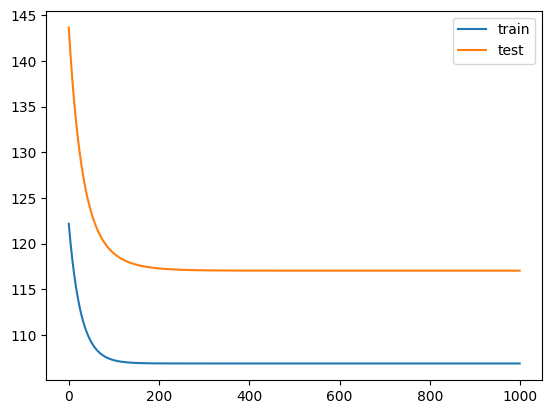

[0.66682758 2.68333229 3.06292209]


In [28]:
X_train, y_train = generate_data([1, 2, 3], 1000, 10.01)
X_test, y_test = generate_data([1, 2, 3], 100, 10.01)
print(solve_sgd_and_plot(X_train, y_train, X_test, y_test, 1000, 0.01))

Now lets remove noise:

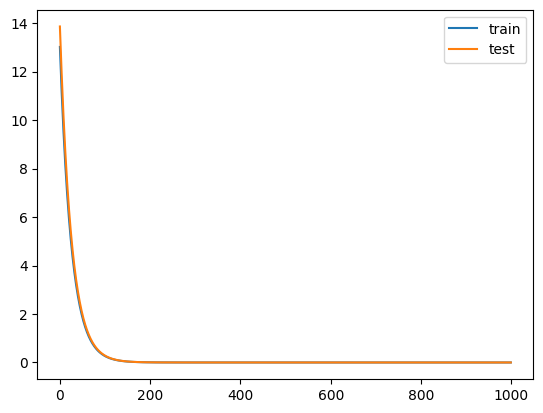

[0.99982778 2.00001431 3.00020538]


In [25]:
X_train, y_train = generate_data([1, 2, 3], 1000, 0.01)
X_test, y_test = generate_data([1, 2, 3], 100, 0.01)
print(solve_sgd_and_plot(X_train, y_train, X_test, y_test, 1000, 0.01))

# Decision trees

## Boosting tree 

In [12]:
import catboost


def solve_catboost(X, y, iterations, learning_rate, depth):
    model = catboost.CatBoostRegressor(iterations = iterations, 
                                       learning_rate = learning_rate, 
                                       depth = depth)
    model.fit(X, y, verbose = False)
    return model
    
    
X_train, y_train = generate_data([1, 2, 3], 1000, 10.01)
X_test, y_test = generate_data([1, 2, 3], 100, 10.01)
model = solve_catboost(X_train, y_train, 1000, 0.1, 6)


def plot_catboost(X_train, y_train, X_test, y_test, model):
    m = model.tree_count_
    train_losses, test_losses = [], []
    for _ in range(m):
        t = model.predict(X_train)
        
        
plot_catboost(X_train, y_train, X_test, y_test, model)